In [5]:
# Import dependencies.
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import pandas as pd

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [7]:
engine = create_engine("sqlite:///open_university.sqlite", echo=False)

In [8]:
dataset = engine.execute(text("""
SELECT sI.id_student, sVle.date, sVle.sum_click, sI.gender, sI.imd_band, sI.highest_education, sI.age_band, sI.num_of_prev_attempts, sI.region, sI.final_result
FROM studentVle as sVle
OUTER LEFT JOIN studentInfo as sI ON sI.id_student = sVle.id_student
OUTER LEFT JOIN vle ON vle.id_site = sVle.id_site AND vle.code_module = sVle.id_site AND vle.code_presentation = sVle.code_presentation
--LIMIT 30
""")).fetchall()

df = pd.DataFrame(dataset, columns=['id_student', 'day', 'clicks', 'gender', 'imd_band', 'highest_education', 'age_band', 'num_of_prev_attempts', 'region', 'final_result'])
display(df.count())
display(df.head())

id_student              13006575
day                     13006575
clicks                  13006575
gender                  13006575
imd_band                12264848
highest_education       13006575
age_band                13006575
num_of_prev_attempts    13006575
region                  13006575
final_result            13006575
dtype: int64

,id_student,day,clicks,gender,imd_band,highest_education,age_band,num_of_prev_attempts,region,final_result
0,28400,-10,4,F,20-30%,HE Qualification,35-55,0,Scotland,Pass
1,28400,-10,1,F,20-30%,HE Qualification,35-55,0,Scotland,Pass
2,28400,-10,1,F,20-30%,HE Qualification,35-55,0,Scotland,Pass
3,28400,-10,11,F,20-30%,HE Qualification,35-55,0,Scotland,Pass
4,28400,-10,1,F,20-30%,HE Qualification,35-55,0,Scotland,Pass


In [9]:
df = df.astype({'gender':'string', 'imd_band':'string', 'highest_education':'string', 'age_band':'string', 'region':'string', 'final_result':'string'})
df.dtypes


id_student                       int64
day                              int64
clicks                           int64
gender                  string[python]
imd_band                string[python]
highest_education       string[python]
age_band                string[python]
num_of_prev_attempts             int64
region                  string[python]
final_result            string[python]
dtype: object

In [10]:
display(df.nunique())
display(df.value_counts("gender"))
display(df.value_counts("imd_band"))
display(df.value_counts("highest_education"))
print(f"A-Level is equivilent to high school cert, HE Qualification is level 1 ro 2 of University, ")
display(df.value_counts("age_band"))
display(df.value_counts("num_of_prev_attempts"))
display(df.value_counts("region"))
display(df.value_counts("final_result"))

id_student              26074
day                       295
clicks                    498
gender                      2
imd_band                   10
highest_education           5
age_band                    3
num_of_prev_attempts        7
region                     13
final_result                4
dtype: int64

gender
M    8354593
F    4651982
Name: count, dtype: int64

imd_band
30-40%     1384419
20-30%     1307201
50-60%     1257308
70-80%     1250483
60-70%     1242688
80-90%     1235303
40-50%     1202012
90-100%    1182047
10-20      1147387
0-10%      1056000
Name: count, dtype: int64

highest_education
A Level or Equivalent          5748707
Lower Than A Level             4546517
HE Qualification               2415485
Post Graduate Qualification     199032
No Formal quals                  96834
Name: count, dtype: int64

A-Level is equivilent to high school cert, HE Qualification is level 1 ro 2 of University, 


age_band
0-35     8280142
35-55    4550454
55<=      175979
Name: count, dtype: int64

num_of_prev_attempts
0    11556117
1     1193004
2      204471
3       36619
4       13324
5        2581
6         459
Name: count, dtype: int64

region
Scotland                1597330
South Region            1327252
East Anglian Region     1278705
London Region           1205387
North Western Region    1082789
South West Region        968971
West Midlands Region     927487
North Region             888017
East Midlands Region     880517
South East Region        838923
Wales                    731838
Yorkshire Region         724879
Ireland                  554480
Name: count, dtype: int64

final_result
Pass           7163176
Distinction    2421423
Withdrawn      1830536
Fail           1591440
Name: count, dtype: int64

In [11]:
# distinction is a higher form of pass
# withdrawn would be a fail if the student would not complete the course both fail and withdrawn is a form of failure.
# Possible to remove withdrawn
df_edited = df.copy()
df_edited["final_result"] = df_edited["final_result"].replace({'Distinction': 'Pass', 'Withdrawn': 'Fail'})
df_edited["final_result"] = df_edited["final_result"].replace({'Pass': '1', 'Fail': '0'})
df_edited = df_edited.astype({'id_student': 'float32', 'day': 'float32', 'clicks': 'float32', 'num_of_prev_attempts': 'float32', 'final_result': 'float32'})
display(df_edited["final_result"].unique())
display(df_edited.dtypes)

array([1., 0.], dtype=float32)

id_student                       int64
day                            float32
clicks                         float32
gender                  string[python]
imd_band                string[python]
highest_education       string[python]
age_band                string[python]
num_of_prev_attempts           float32
region                  string[python]
final_result                   float32
dtype: object

In [12]:
df_edited = pd.get_dummies(df_edited)
df_edited.head()

,id_student,day,clicks,num_of_prev_attempts,final_result,gender_F,gender_M,imd_band_0-10%,imd_band_10-20,imd_band_20-30%,...,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region
0,28400,-10.0,4.0,0.0,1.0,True,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
1,28400,-10.0,1.0,0.0,1.0,True,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
2,28400,-10.0,1.0,0.0,1.0,True,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
3,28400,-10.0,11.0,0.0,1.0,True,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
4,28400,-10.0,1.0,0.0,1.0,True,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False


In [13]:
# combine pass and distinction
# combine widthdrawn and fail
X = df_edited.drop('final_result', axis=1).values
y = df_edited['final_result'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)


In [14]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

X_train_scaled.shape

(9754931, 37)

In [21]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])

# X shape / input feature / columns rule of thumbs is normally 2-3 times the ammount so 43 * 2 or 3 is 86-129 so i will try choosing 90 for the first hidden node
hidden_nodes1 = 90
hidden_nodes2 = 60
hidden_nodes3 = 30

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes1, input_shape=(number_input_features,), activation='relu'))
# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes2, activation='relu'))
# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes3, activation='relu'))
# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
# Check the structure of the model
nn.summary()

/Users/horsewell/anaconda3/envs/dev/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 90)             │         3,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 60)             │         5,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,741 (41.96 KB)

 Trainable params: 10,741 (41.96 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Compile the model
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train, epochs=20)

Epoch 1/20
304842/304842 ━━━━━━━━━━━━━━━━━━━━ 136s 445us/step - accuracy: 0.7895 - loss: 0.4465
Epoch 2/20
304842/304842 ━━━━━━━━━━━━━━━━━━━━ 135s 441us/step - accuracy: 0.8283 - loss: 0.3654
Epoch 3/20
304842/304842 ━━━━━━━━━━━━━━━━━━━━ 134s 440us/step - accuracy: 0.8384 - loss: 0.3444
Epoch 4/20
304842/304842 ━━━━━━━━━━━━━━━━━━━━ 134s 440us/step - accuracy: 0.8437 - loss: 0.3333
Epoch 5/20
304842/304842 ━━━━━━━━━━━━━━━━━━━━ 134s 441us/step - accuracy: 0.8474 - loss: 0.3257
Epoch 6/20
304842/304842 ━━━━━━━━━━━━━━━━━━━━ 135s 442us/step - accuracy: 0.8499 - loss: 0.3203
Epoch 7/20
304842/304842 ━━━━━━━━━━━━━━━━━━━━ 134s 441us/step - accuracy: 0.8522 - loss: 0.3162
Epoch 8/20
304842/304842 ━━━━━━━━━━━━━━━━━━━━ 134s 440us/step - accuracy: 0.8534 - loss: 0.3136
Epoch 9/20
304842/304842 ━━━━━━━━━━━━━━━━━━━━ 134s 439us/step - accuracy: 0.8547 - loss: 0.3112
Epoch 10/20
304842/304842 ━━━━━━━━━━━━━━━━━━━━ 134s 439us/step - accuracy: 0.8553 - loss: 0.3098
Epoch 11/20
304842/304842 ━━━━━━━━━━━━━

In [24]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

101614/101614 - 30s - 291us/step - accuracy: 0.8584 - loss: 0.3017
Loss: 0.30168959498405457, Accuracy: 0.8584054708480835


In [25]:
# Export our model to HDF5 file
nn.save("models/Student_PassFail_relu90+relu60+relu30+sigmoid.h5")

<Axes: >

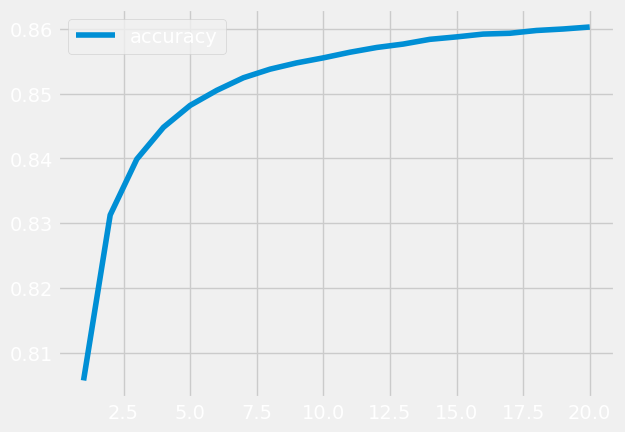

In [26]:
# plotting the accuracy
df_edited = pd.DataFrame(fit_model.history, index = range(1, len(fit_model.history['loss'])+1))
df_edited.plot(y = 'accuracy')